In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as intg
import math
from pathlib import Path

flight_60 = pd.read_csv('FlightData60k.csv')
flight_10 = pd.read_csv('MRT Porthos official Flight data 2023.csv')

def format_flight_data(flight_10, flight_60):

    flight_60.drop(flight_60.columns.difference(['Time', 'Altitude', 'Total Velocity']), axis=1, inplace=True)
    flight_60.rename(columns={'Time': 'Time_60k', 'Altitude': 'Altitude_60k', 'Total Velocity': 'Velocity_60k'}, inplace=True)

    flight_10.drop(flight_10.columns.difference(['Time', 'Altitude', 'Velocity']), axis=1, inplace=True)
    flight_10.rename(columns={'Time': 'Time_10k', 'Altitude': 'Altitude_10k', 'Velocity': 'Velocity_10k'}, inplace=True)


# Altitude vs time for 10k and 60k

c:\Users\karlu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:1290: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\karlu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:1291: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\karlu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:1292: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\karlu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


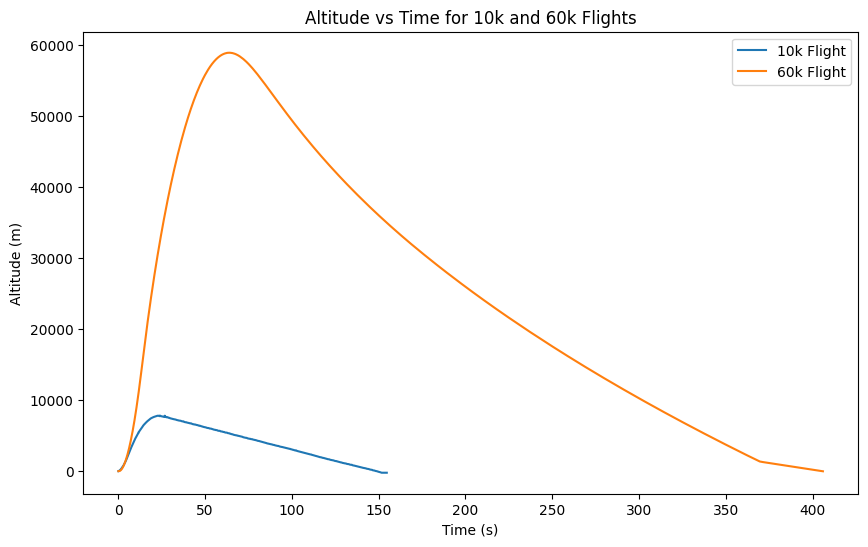

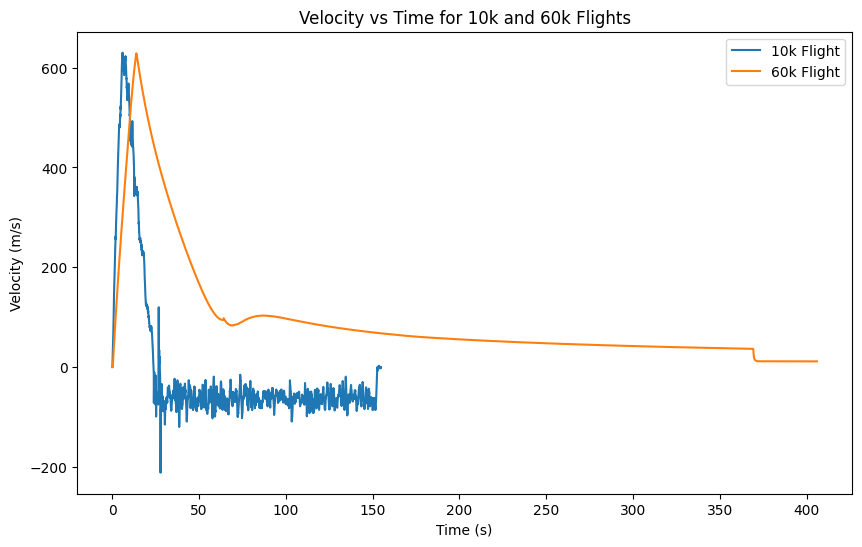

<Figure size 1000x600 with 0 Axes>

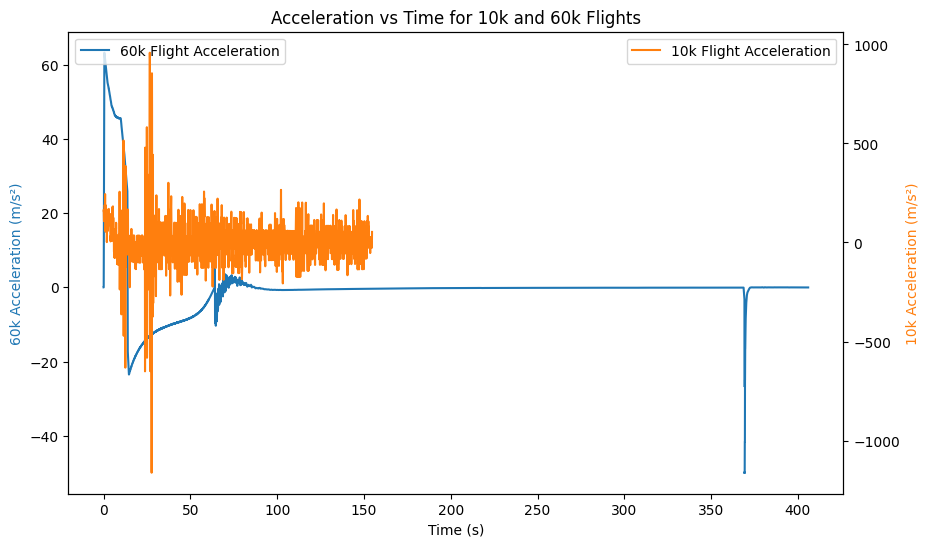

In [46]:
def altitude_vs_time(flight_10, flight_60):

    plt.figure(figsize=(10, 6))
    plt.plot(flight_10['Time_10k'], flight_10['Altitude_10k'], label='10k Flight')
    plt.plot(flight_60['Time_60k'], flight_60['Altitude_60k'], label='60k Flight')

    plt.xlabel('Time (s)')
    plt.ylabel('Altitude (m)')
    plt.title('Altitude vs Time for 10k and 60k Flights')
    plt.legend()

def altitude_vs_velocity(flight_10, flight_60):

    plt.figure(figsize=(10, 6))
    plt.plot(flight_10['Time_10k'], flight_10['Velocity_10k'], label='10k Flight')
    plt.plot(flight_60['Time_60k'], flight_60['Velocity_60k'], label='60k Flight')

    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity vs Time for 10k and 60k Flights')
    plt.legend()

def acceleration_vs_time(flight_10, flight_60):

    plt.figure(figsize=(10, 6))
    # Compute acceleration as numerical derivative of velocity
    a_10k = np.gradient(flight_10['Velocity_10k'], flight_10['Time_10k'])
    a_60k = np.gradient(flight_60['Velocity_60k'], flight_60['Time_60k'])

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.plot(flight_60['Time_60k'], a_60k, color='tab:blue', label='60k Flight Acceleration')
    ax2.plot(flight_10['Time_10k'], a_10k, color='tab:orange', label='10k Flight Acceleration')

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('60k Acceleration (m/s²)', color='tab:blue')
    ax2.set_ylabel('10k Acceleration (m/s²)', color='tab:orange')
    ax1.set_title('Acceleration vs Time for 10k and 60k Flights')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')



format_flight_data(flight_10, flight_60)
altitude_vs_time(flight_10, flight_60)
altitude_vs_velocity(flight_10, flight_60)
acceleration_vs_time(flight_10, flight_60)

# Antenna Mount (10k)

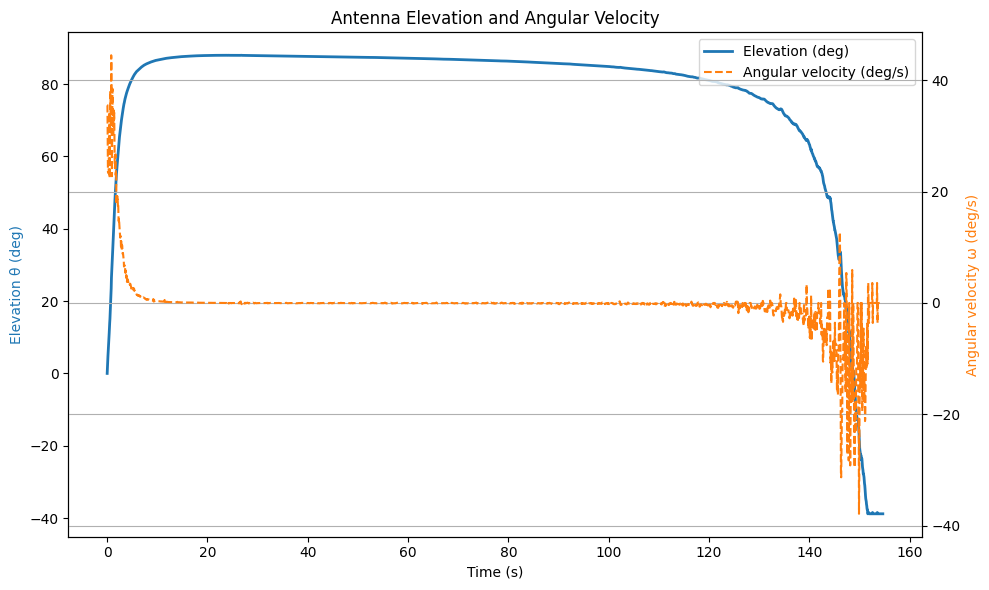

In [ ]:
def mount_kinetics(time, altitude, dist_to_pad, dist_to_pad_ft = False):

    time = np.asarray(time, dtype=float)
    altitude = np.asarray(altitude, dtype=float)

    if dist_to_pad_ft:
        dist = dist_to_pad * 0.3048  # convert ft to m
    else:
        dist = dist_to_pad  # already in meters

    if time.ndim != 1 or altitude.ndim != 1:
        raise ValueError("Input arrays must be one-dimensional.")
    if time.shape[0] != altitude.shape[0]:
        raise ValueError("Input arrays must have the same length.")
    if np.any(np.diff(time) <= 0):
        raise ValueError("Time array must be strictly increasing.")

    theta_rad = np.arctan2(altitude, dist)
    theta_deg = np.degrees(theta_rad)

    omega_rad = np.gradient(theta_rad, time)
    omega_deg = np.degrees(omega_rad)

    alpha_rad = np.gradient(omega_rad, time)
    alpha_deg = np.degrees(alpha_rad)

    df = pd.DataFrame({
        'time_10k': time,
        'theta_rad_10k': theta_rad,
        'theta_10k': theta_deg,
        'omega_rad_10k': omega_rad,
        'omega_10k': omega_deg,
        'alpha_rad_10k': alpha_rad,
        'alpha_10k': alpha_deg
    })
    return df


# Example usage with 10k flight data
dist_to_pad_m = 900 * 0.3048

mags = mount_kinetics(
    time=flight_10['Time_10k'].to_numpy(),
    altitude=flight_10['Altitude_10k'].to_numpy(),
    dist_to_pad=dist_to_pad_m,
    dist_to_pad_ft=False
)


fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(mags['time_10k'], mags['theta_10k'], color='tab:blue', label='Elevation (deg)', linewidth=2)
ax2.plot(mags['time_10k'], mags['omega_10k'], color='tab:orange', label='Angular velocity (deg/s)', linestyle='--')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Elevation θ (deg)', color='tab:blue')
ax2.set_ylabel('Angular velocity ω (deg/s)', color='tab:orange')
ax1.set_title('Antenna Elevation and Angular Velocity')

# optional combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()



